## Poisson with overdispersion Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures in the first simulation in the paper. 

In this example simulate under GLMM with $\beta = log(5)$

In this example we have Poisson base distribution with Log Link function and covariance matrix $\Gamma$ structured under $\Gamma = 0.05 * I$

We run each scenario 100 times.

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

┌ Info: Precompiling GLMCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1342


In [16]:
p  = 1    # number of fixed effects, including intercept

# true parameter values
Random.seed!(1234)
βtrue = log(5.0)
θtrue = [0.05]

# generate data
trueparams = [βtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2]
nsims = 100

100

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


300-element Vector{Float64}:
 0.034299029
 0.031682737
 0.030676151
 0.026450753
 0.032717942
 0.036815838
 0.027300573
 0.037443328
 0.036993945
 0.038319806
 0.027821053
 0.027347655
 0.037211649
 ⋮
 0.617354569
 0.613514833
 0.580084776
 1.608259904
 0.810405702
 0.692325143
 0.500374856
 1.53422909
 1.50369435
 0.808732245
 0.711493914
 0.619807494

In [7]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + 2 * timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0320231,0.000525448,200,0.0314976,0.033074,0.000160115
2,1000,2,0.0860226,0.00146063,2000,0.0845619,0.0889438,4.30113e-5
3,10000,2,0.79878,0.0333844,20000,0.765396,0.865549,3.9939e-5


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


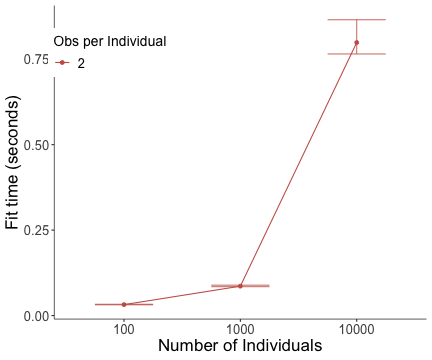

RObject{VecSxp}


In [11]:
########### plot the runtimes
using RCall
@rput timedf1

R"""
library(ggplot2)
timedf1$obssize = factor(timedf1$obssize, levels = c('2'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")
"""

In [12]:
R"""
ggsave('fittimes_nobs_poisson_overdispersion.png', fittime_1, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittimes_nobs_poisson_overdispersion.png"


In [17]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθcoverage = readdlm("beta_sigma_coverage_multivariate_poisson_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βθcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,θ1
,String,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.92, 0.027266)","(0.93, 0.0256432)"
2,N: 1000 ni: 2,"(0.95, 0.0219043)","(0.0, 0.0)"
3,N: 10000 ni: 2,"(0.87, 0.0337998)","(0.0, 0.0)"


In [20]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem


βMseresult = vec(readdlm("mse_beta_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

samplesizesrobust = samplesizes
nsrobust = ns
nsimsrobust = nsims

# βMseresultnorm = vec(readdlm("result_files/mse_beta_normal_normal_lognormal_1000reps_sim.csv", ','))
# τMseresultnorm = vec(readdlm("result_files/mse_tau_normal_normal_lognormal_1000reps_sim.csv", ','))
# ΣMseresultnorm = vec(readdlm("result_files/mse_Sigma_normal_normal_lognormal_1000reps_sim.csv", ','))
# βτcoveragenorm = readdlm("result_files/beta_tau_coverage_5betas_normal_normal_lognormal_1000reps_sim.csv", ',')


# samplesizesnorm = collect(1000:1000:6000)
# nsnorm = [10; 25; 50; 100; 1000]
# nsimsnorm = 1000

p = 3
sample_sizesrobust = repeat(string.(samplesizesrobust), inner = nsimsrobust * length(nsrobust))
obs_sizesrobust = repeat(string.(nsrobust), inner = nsimsrobust, outer = length(samplesizesrobust))
msedfrobust = DataFrame(βmse = βMseresult, θMse = θMseresult,
    samplesize = sample_sizesrobust, obssize = obs_sizesrobust)

msedfrobustR = deepcopy(msedfrobust)
rename!(msedfrobustR, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);


mses = [msedfrobustR[!, :betamse]; msedfrobustR[!, :thetamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = collect([repeat(msedfrobustR[!, :obssize], 2)]...) # ; repeat(msedfnormR[!, :obssize], 3)]

samplesize = collect([repeat(msedfrobustR[!, :samplesize], 2)]...) # ; repeat(msedfnormR[!, :samplesize], 3)]

parameters = collect([repeat(string.([:beta, :theta]), inner = nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...)
# ; repeat(string.([:beta, :tau, :Sigma]), inner = nsimsnorm * length(nsnorm) * length(samplesizesnorm))]
robust = collect([repeat(["Poisson with LogLink"], 2 * nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...) # ;
# repeat(["Normal Normal Log-Normal"], 3 * nsimsnorm * length(nsnorm) * length(samplesizesnorm))];

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,6.32009e-5,2,100,beta,Poisson with LogLink
2,0.00165626,2,100,beta,Poisson with LogLink
3,0.000318028,2,100,beta,Poisson with LogLink
4,0.00256225,2,100,beta,Poisson with LogLink
5,0.000928898,2,100,beta,Poisson with LogLink
6,0.00218237,2,100,beta,Poisson with LogLink
7,0.00188609,2,100,beta,Poisson with LogLink
8,0.00148271,2,100,beta,Poisson with LogLink
9,0.000606173,2,100,beta,Poisson with LogLink


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


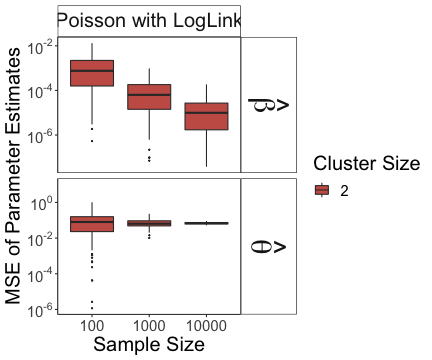

RObject{VecSxp}


In [21]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-6]
msedfR[parameters == "beta",y_max := 10^-2]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta)))))
msedfR$robust = factor(msedfR$robust, levels = c('Poisson with LogLink'),
    labels = c(expression(paste("Poisson with LogLink")))) # , expression(paste("MvT Gamma Inverse-Gamma"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=15),
        axis.text.y = element_text(angle=0, size=15), axis.title.x = element_text(size = 20), 
        axis.title.y = element_text(size = 20), legend.title = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=15), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=30, face="bold"),
        strip.text.x = element_text(size=20)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [22]:
R"""
ggsave('updated_msefacetplot_poisson_overdispersion.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_poisson_overdispersion.png"
